<a href="https://colab.research.google.com/github/parmarsuraj99/numerai-guides/blob/master/signals_toronto/signals_Intro_feb_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to Medium post:[Let's talk about Signals](https://parmarsuraj99.medium.com/lets-talk-about-signals-841934f24450)

## Libraries and imports

In [ ]:
!pip install numerapi
!pip install yfinance
!pip install simplejson

!pip install catboost
!pip install -U git+https://github.com/parmarsuraj99/opensignals.git@master

In [ ]:
import gc, os

import numerapi
import simplejson
import yfinance

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from opensignals.data.yahoo import Yahoo
from typing import *

import time

from itertools import repeat
from multiprocessing import Pool
from multiprocessing import cpu_count

from concurrent import futures
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

import multiprocessing
import pandas as pd

from joblib import Parallel
from joblib import delayed
from tqdm.auto import tqdm

import requests

from datetime import datetime
from dateutil.relativedelta import FR
from dateutil.relativedelta import relativedelta


pd.set_option('display.max_columns', 500)

## Data acquisition

Getting the tickers in latest Universe using NumerAPI

In [ ]:
napi = numerapi.SignalsAPI()

eligible_tickers = pd.Series(napi.ticker_universe(), name="bloomberg_ticker")
print(f"Number of eligible tickers : {len(eligible_tickers)}")

print(eligible_tickers.head(10))

Number of eligible tickers : 5341
0    SVW AU
1    GEM AU
2    AZJ AU
3    NXT AU
4    TWE AU
5    SGR AU
6    CKF AU
7    BGA AU
8    QUB AU
9    AX1 AU
Name: bloomberg_ticker, dtype: object


This file has mapping from bloomberg to yahoo finance tickers.
So, we can use yfinance tickers to download and then map/rename them back to bloomberg tickers.

In [ ]:
# downloadin and saving raw stock market data for tickers above
db_dir = Path('db')

yahoo = Yahoo()
#yahoo.download_data(db_dir)

In [ ]:
# Loading data from saved file
# Open Signals maps the tickers form yahoo to bloomberg tickers

db_dir = Path('db')
full_df = Yahoo.get_ticker_data(db_dir)
gc.collect()

2022-02-26 05:40:00,930 INFO opensignals.data.provider: Retrieving data for 5263 tickers from the database


11

In [ ]:
full_df.head()

,date,bloomberg_ticker,open,high,low,close,adj_close,volume,currency,provider,created_at
0,2002-12-02,000270 KS,9100.0,9100.0,9100.0,9100.0,6372.125000,0.0,KRW,yahoo,2022-02-25 19:11:57.887342
1,2002-12-03,000270 KS,9610.0,10050.0,9410.0,9990.0,6995.333008,2761100.0,KRW,yahoo,2022-02-25 19:11:57.887342
2,2002-12-04,000270 KS,9800.0,9880.0,9520.0,9600.0,6722.241699,1618400.0,KRW,yahoo,2022-02-25 19:11:57.887342
3,2002-12-05,000270 KS,9750.0,10050.0,9620.0,10050.0,7037.348145,1696700.0,KRW,yahoo,2022-02-25 19:11:57.887342
4,2002-12-06,000270 KS,9850.0,10200.0,9700.0,9780.0,6848.283691,1500300.0,KRW,yahoo,2022-02-25 19:11:57.887342


In [ ]:
def adjust_ohlc(df: pd.DataFrame) -> pd.DataFrame:

    """
    Adjusting OHLC using already adjusted close price
    """

    ratio = df["adj_close"] / df["close"]

    for col in ["open", "high", "low", "close"]:
        df[col] = df[col] * ratio
        gc.collect()

    return df[
        [
            "bloomberg_ticker",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "adj_close",
            "date",
        ]
    ]


In [ ]:
full_df = adjust_ohlc(full_df)
gc.collect()

0

In [ ]:
# a ticker's data
full_df.groupby("bloomberg_ticker").get_group("AAPL US")

,bloomberg_ticker,open,high,low,close,volume,adj_close,date
4777244,AAPL US,0.244151,0.247222,0.230485,0.233095,398742400.0,0.233095,2002-12-02
4777245,AAPL US,0.233403,0.235552,0.231867,0.232788,227869600.0,0.232788,2002-12-03
4777246,AAPL US,0.233095,0.233249,0.222654,0.229870,325757600.0,0.229870,2002-12-04
4777247,AAPL US,0.230792,0.231560,0.223114,0.224650,243398400.0,0.224650,2002-12-05
4777248,AAPL US,0.224957,0.233249,0.222961,0.229563,245358400.0,0.229563,2002-12-06
...,...,...,...,...,...,...,...,...
4782081,AAPL US,171.029999,171.910004,168.470001,168.880005,69589296.0,168.880005,2022-02-17
4782082,AAPL US,169.820007,170.539993,166.190002,167.300003,82614200.0,167.300003,2022-02-18
4782083,AAPL US,164.979996,166.690002,162.149994,164.320007,91162800.0,164.320007,2022-02-22
4782084,AAPL US,165.539993,166.149994,159.750000,160.070007,90009200.0,160.070007,2022-02-23


In [ ]:
# a day's data
full_df.groupby("date").get_group("2022-02-17")

,bloomberg_ticker,open,high,low,close,volume,adj_close,date
4798,000270 KS,79200.000000,79900.000,78400.00,79500.000000,1906307.0,79500.000000,2022-02-17
9603,000120 KS,124000.000000,125500.000,120500.00,123000.000000,43336.0,123000.000000,2022-02-17
14408,000080 KS,34800.000000,35200.000,33850.00,34750.000000,692116.0,34750.000000,2022-02-17
19204,000990 KS,72500.000000,73300.000,69400.00,71400.000000,1432925.0,71400.000000,2022-02-17
24009,001040 KS,83300.000000,84400.000,81800.00,83600.000000,49414.0,83600.000000,2022-02-17
...,...,...,...,...,...,...,...,...
19151704,ZWS US,34.150002,34.590,33.68,33.880001,1049900.0,33.880001,2022-02-17
19156237,ZYXI US,7.180000,7.260,5.62,6.160000,1994300.0,6.160000,2022-02-17
19157896,ZZZ CN,32.759998,32.805,31.99,32.110001,93300.0,32.110001,2022-02-17
19162827,ZOT SM,7.050000,7.060,7.05,7.050000,838322.0,7.050000,2022-02-17


In [ ]:
print(f"Number of tickers with data: {len(full_df.bloomberg_ticker.unique())}")

Number of tickers with data: 5263


## Technical Indicators

In [ ]:
def RSI(prices, period=14):

    '''
    Computes Relative Strength Index given a price series and lookback interval
    Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
    See more here https://www.investopedia.com/terms/r/rsi.asp
    '''

    prices = prices["close"]
    delta = prices.diff()

    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(period).mean()
    RolDown = dDown.rolling(period).mean().abs()

    RS = RolUp / RolDown
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return pd.Series(RSI, name=f"rsi_{period}")

def sma(prices: pd.Series, period: int) -> pd.Series:

    """
    Simple Moving Average
    """
    
    prices = prices["close"]
    res = prices.rolling(period).mean()
    return pd.Series(res, name=f"sma_{period}")

def ema(prices: pd.Series, period: int) -> pd.Series:

    """
    Exponential Moving Average
    """

    prices = prices["close"]
    res = prices.ewm(span=period).mean()
    return pd.Series(res, name=f"ema_{period}")

def MFI(df, period=14):

    """
    Money Flow Index - Like RSI but using volume
    """

    typical_price = (df['close'] + df['high'] + df['low']) / 3
    money_flow = typical_price * df['volume']

    delta = money_flow.diff()

    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(period).mean()
    RolDown = dDown.rolling(period).mean().abs()

    RS = RolUp / RolDown
    MFI = 100.0 - (100.0 / (1.0 + RS))
    return pd.Series(MFI, name=f"mfi_{period}").astype(np.float32)

In [ ]:
# indicating features to generate
# "feature_name:period_1:period:_2:..."

indicators = [
         "MFI:14:21",     
         "RSI:14:21",
         "sma:7:21:50",
         "ema:7:21:50",
         ]

gc.collect()
full_df["d_index"] = full_df.index

# sort by tickers ensuring correct results in grouped parallel ops
full_df = full_df.sort_values(["bloomberg_ticker", "d_index"]).copy()
gc.collect()


grouped = full_df.groupby("bloomberg_ticker")
gc.collect()

def group_apply_with_name(dfGroup, func, name, **kwargs):
    
    """
    Arbitary function to apply specified function name with args
    """

    res = func(dfGroup.sort_index(), **kwargs)
    return res

def applyParallel(dfGrouped, func, feature,**kwargs):
    """
    Parallalize over ticker groups
    """
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(func)(group, feature, name=name, **kwargs) for name, group in tqdm(dfGrouped)
        )
    return pd.concat(retLst)

res_list = []

# iterate over technical indicators
for indicator in tqdm(indicators):

    # split for multiple periods
    split = indicator.split(":")
    if len(split) == 1:

        # case for no specified period - default period

        print(method_to_call)
        method_to_call = globals()[indicator]
        res = applyParallel(grouped, group_apply_with_name,
                            method_to_call).astype(np.float32)
        res_list.append(res)
    else:

        # case for no specified period - default period
        # iterate over periods

        for num in split[1:]:
            method_to_call = globals()[split[0]]
            print(method_to_call, num)
            res = applyParallel(grouped, group_apply_with_name,
                                method_to_call, period=int(num)).astype(np.float32)
            res_list.append(res)
            gc.collect()

del grouped
gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

<function MFI at 0x7f1948e33560> 14


  0%|          | 0/5263 [00:00<?, ?it/s]

<function MFI at 0x7f1948e33560> 21


  0%|          | 0/5263 [00:00<?, ?it/s]

<function RSI at 0x7f1948ebe170> 14


  0%|          | 0/5263 [00:00<?, ?it/s]

<function RSI at 0x7f1948ebe170> 21


  0%|          | 0/5263 [00:00<?, ?it/s]

<function sma at 0x7f1948ebe320> 7


  0%|          | 0/5263 [00:00<?, ?it/s]

<function sma at 0x7f1948ebe320> 21


  0%|          | 0/5263 [00:00<?, ?it/s]

<function sma at 0x7f1948ebe320> 50


  0%|          | 0/5263 [00:00<?, ?it/s]

<function ema at 0x7f1948e33a70> 7


  0%|          | 0/5263 [00:00<?, ?it/s]

<function ema at 0x7f1948e33a70> 21


  0%|          | 0/5263 [00:00<?, ?it/s]

<function ema at 0x7f1948e33a70> 50


  0%|          | 0/5263 [00:00<?, ?it/s]

9495

In [ ]:
ret = pd.concat(res_list, 1)
del res_list

gc.collect()
new_indicators = ret.columns
ret

,mfi_14,mfi_21,rsi_14,rsi_21,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50
76835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602.486389,602.486389,602.486389
76836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,609.326294,608.756287,608.591003
76837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,595.153381,596.983521,597.481201
76838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,586.891296,589.979553,590.872620
76839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,582.848145,586.280884,587.343262
...,...,...,...,...,...,...,...,...,...,...
19157896,52.222534,51.093681,21.897392,22.762276,32.813084,34.687000,36.122387,32.965977,34.397774,35.458832
19157897,48.269386,49.752239,22.463902,25.643637,32.560307,34.454105,35.999519,32.689480,34.167068,35.317703
19157898,46.931225,48.941280,14.553805,23.638109,32.236965,34.180645,35.859219,32.192112,33.851879,35.136616
19157899,58.065453,52.377228,13.806841,22.961990,31.955853,33.891914,35.711708,31.709084,33.525345,34.945377


In [ ]:
# concatenation to original df needs memory
# use cols from full_df on result
ret.loc[:, "bloomberg_ticker"] = full_df["bloomberg_ticker"].values
ret.loc[:, "adj_close"] = full_df["adj_close"].values
ret.loc[:, "date"] = full_df["date"].values
gc.collect()

full_df = ret.copy()
del ret
gc.collect()
full_df.set_index("date", inplace=True)
full_df = full_df.dropna(axis=0)
gc.collect()

13

In [ ]:
full_df

,mfi_14,mfi_21,rsi_14,rsi_21,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50,bloomberg_ticker,adj_close
date,,,,,,,,,,,,
2003-02-07,40.162048,49.134438,36.559124,34.999985,462.837189,484.687042,526.277771,464.900269,480.193756,502.519775,000060 KS,462.837128
2003-02-10,46.967247,49.286930,39.534889,34.426228,465.687164,481.077057,523.405029,463.387024,478.238007,500.551208,000060 KS,458.847229
2003-02-11,50.393333,50.746490,45.348850,34.426228,469.962128,477.467072,520.492310,464.745789,477.375946,499.129364,000060 KS,468.822144
2003-02-12,52.156631,46.301655,51.648354,37.499981,471.387115,474.427094,518.656921,469.754852,478.053558,498.489990,000060 KS,484.781982
2003-02-13,53.012657,52.408001,63.529423,40.740734,473.097107,472.052124,517.180664,477.002869,479.945801,498.501373,000060 KS,498.746948
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,52.222534,51.093681,21.897392,22.762276,32.813084,34.687000,36.122387,32.965977,34.397774,35.458832,ZZZ CN,32.110001
2022-02-18,48.269386,49.752239,22.463902,25.643637,32.560307,34.454105,35.999519,32.689480,34.167068,35.317703,ZZZ CN,31.860001
2022-02-22,46.931225,48.941280,14.553805,23.638109,32.236965,34.180645,35.859219,32.192112,33.851879,35.136616,ZZZ CN,30.700001


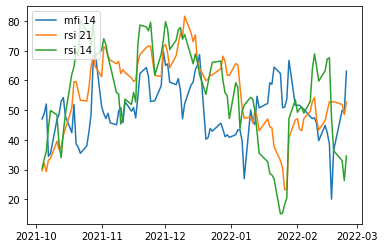

In [ ]:
ticker = "AAPL US"
plt.plot(full_df[full_df['bloomberg_ticker']==ticker]["mfi_14"][-100:], label='mfi 14')
plt.plot(full_df[full_df['bloomberg_ticker']==ticker]["rsi_21"][-100:], label='rsi 21')
plt.plot(full_df[full_df['bloomberg_ticker']==ticker]["rsi_14"][-100:], label='rsi 14')
plt.legend(loc='upper left')

plt.show()

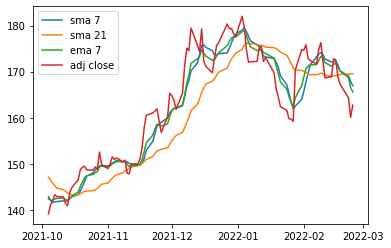

In [ ]:
plt.plot(full_df[full_df['bloomberg_ticker']==ticker]["sma_7"][-100:], label='sma 7')
plt.plot(full_df[full_df['bloomberg_ticker']==ticker]["sma_21"][-100:], label='sma 21')
plt.plot(full_df[full_df['bloomberg_ticker']==ticker]["ema_7"][-100:], label='ema 7')
plt.plot(full_df[full_df['bloomberg_ticker']==ticker]["adj_close"][-100:], label='adj close')
plt.legend(loc='upper left')

plt.show()

In [ ]:
# getting indicator groups for crossovers

sma_features = [f for f in full_df.columns if "sma" in f]
ema_features = [f for f in full_df.columns if "ema" in f]
rsi_features = [f for f in full_df.columns if "rsi" in f]
mfi_features = [f for f in full_df.columns if "mfi" in f]

In [ ]:
# calculating crossovers between all possible 
# combinations within an indicator periods

for grp in [sma_features, ema_features, rsi_features, mfi_features]:
    for f1, f2 in tqdm(combinations(grp, 2)):

        col_name = f1 + " minus " + f2
        full_df.loc[:, col_name] = (full_df[f1] / full_df[f2] - 1).astype(np.float16).values
        gc.collect()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
full_df

,mfi_14,mfi_21,rsi_14,rsi_21,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50,bloomberg_ticker,adj_close,sma_7 minus sma_21,sma_7 minus sma_50,sma_21 minus sma_50,ema_7 minus ema_21,ema_7 minus ema_50,ema_21 minus ema_50,rsi_14 minus rsi_21,mfi_14 minus mfi_21
date,,,,,,,,,,,,,,,,,,,,
2003-02-07,40.162048,49.134438,36.559124,34.999985,462.837189,484.687042,526.277771,464.900269,480.193756,502.519775,000060 KS,462.837128,-0.045074,-0.120544,-0.079041,-0.031860,-0.074890,-0.044434,0.044556,-0.182617
2003-02-10,46.967247,49.286930,39.534889,34.426228,465.687164,481.077057,523.405029,463.387024,478.238007,500.551208,000060 KS,458.847229,-0.031982,-0.110291,-0.080872,-0.031052,-0.074219,-0.044586,0.148438,-0.047058
2003-02-11,50.393333,50.746490,45.348850,34.426228,469.962128,477.467072,520.492310,464.745789,477.375946,499.129364,000060 KS,468.822144,-0.015717,-0.097107,-0.082642,-0.026459,-0.068909,-0.043579,0.317383,-0.006958
2003-02-12,52.156631,46.301655,51.648354,37.499981,471.387115,474.427094,518.656921,469.754852,478.053558,498.489990,000060 KS,484.781982,-0.006409,-0.091125,-0.085266,-0.017365,-0.057648,-0.040985,0.377197,0.126465
2003-02-13,53.012657,52.408001,63.529423,40.740734,473.097107,472.052124,517.180664,477.002869,479.945801,498.501373,000060 KS,498.746948,0.002214,-0.085266,-0.087280,-0.006130,-0.043121,-0.037231,0.559570,0.011536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,52.222534,51.093681,21.897392,22.762276,32.813084,34.687000,36.122387,32.965977,34.397774,35.458832,ZZZ CN,32.110001,-0.054016,-0.091614,-0.039734,-0.041626,-0.070312,-0.029922,-0.037994,0.022095
2022-02-18,48.269386,49.752239,22.463902,25.643637,32.560307,34.454105,35.999519,32.689480,34.167068,35.317703,ZZZ CN,31.860001,-0.054962,-0.095520,-0.042938,-0.043243,-0.074402,-0.032593,-0.124023,-0.029800
2022-02-22,46.931225,48.941280,14.553805,23.638109,32.236965,34.180645,35.859219,32.192112,33.851879,35.136616,ZZZ CN,30.700001,-0.056854,-0.101013,-0.046814,-0.049042,-0.083801,-0.036560,-0.384277,-0.041077


In [ ]:
# quantiling the generated features
# parallalized over date groups

feature_names = [c for c in full_df.columns if c not in ["bloomberg_ticker"]]
len(feature_names)

date_groups = full_df.groupby(full_df.index)

def group_apply_with_name(dfGroup, name, **kwargs):
    res = pd.qcut(dfGroup, 5, labels=False, duplicates='drop')
    #res["bloomberg_ticker"] = name
    return res

def applyParallel(dfGrouped, func, **kwargs):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(func)(group, name=name, **kwargs) for name, group in dfGrouped
        )
    return pd.concat(retLst)

res_list = []
for indicator in tqdm(feature_names):
    print(indicator)
    res = applyParallel(date_groups[indicator], group_apply_with_name).astype(np.float16)
    res_list.append(res)
    gc.collect()
    

ret = pd.concat(res_list, 1)
del date_groups
del res_list

gc.collect()

  0%|          | 0/19 [00:00<?, ?it/s]

mfi_14
mfi_21
rsi_14
rsi_21
sma_7
sma_21
sma_50
ema_7
ema_21
ema_50
adj_close
sma_7 minus sma_21
sma_7 minus sma_50
sma_21 minus sma_50
ema_7 minus ema_21
ema_7 minus ema_50
ema_21 minus ema_50
rsi_14 minus rsi_21
mfi_14 minus mfi_21


20

In [ ]:
gc.collect()

# sorted by date first because res was grouped over date column
ret["bloomberg_ticker"] = full_df.sort_values(["date", "bloomberg_ticker"])["bloomberg_ticker"]
gc.collect()

full_df = ret.copy()
del ret
gc.collect()

0

In [ ]:
full_df[list(sma_features + ema_features+ rsi_features+ mfi_features) + ["bloomberg_ticker"]]

,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50,rsi_14,rsi_21,mfi_14,mfi_21,bloomberg_ticker
date,,,,,,,,,,,
2003-02-06,3.0,3.0,3.0,3.0,3.0,3.0,4.0,2.0,4.0,1.0,AGL AU
2003-02-06,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,4.0,4.0,AIA NZ
2003-02-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,APA AU
2003-02-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,API AU
2003-02-06,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,AWC AU
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,4.0,4.0,9962 JP
2022-02-25,4.0,4.0,4.0,4.0,4.0,4.0,2.0,0.0,0.0,0.0,9983 JP
2022-02-25,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,2.0,9984 JP


Let's encode lagged indicators as features

In [ ]:
ticker_groups = full_df.groupby("bloomberg_ticker")
#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc

res_list = []
for indicator in tqdm(new_indicators):

    # num_days for max lag
    num_days = 21

    # calculating lags in multiple of 5 
    # 0, 5, 10, 15, 20
    # can be added more with more efficient calculation
    for day in range(0, num_days + 1, 5)[1:]:
        res = ticker_groups[
            f"{indicator}"
        ].transform(lambda group: group.shift(day))
        res.rename(f"{indicator}_lag_{day}", inplace=True)

        res_list.append(res)

    gc.collect()

del ticker_groups
gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

21

In [ ]:
lag_list = pd.concat(res_list, 1)
del res_list
gc.collect()

150

In [ ]:
# create difference of the lagged features (change in RSI quintile by day)
# can be done before quantilation too (lag, abs_diff_lags)

res_list = []
for indicator in new_indicators:
    for day in tqdm(range(0, num_days-5, 5)[1:]):

        # lag represnets a direction of change
        res = (
            lag_list[f"{indicator}_lag_{day}"]
            - lag_list[f"{indicator}_lag_{day + 5}"]
        )
        res.rename(f"{indicator}_diff_{day}", inplace=True)

        # absolute difference
        res_abs = np.abs(res)
        res_abs.rename(f"{indicator}_abs_diff_{day}", inplace=True)

        #res_list.append(res)  # saving only absolute difference
        res_list.append(res_abs)

    gc.collect()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
diff_list = pd.concat(res_list, axis=1)
del res_list

gc.collect()

In [ ]:
full_df = pd.concat([full_df, lag_list], 1)
del lag_list
gc.collect()

full_df = pd.concat([full_df, diff_list], 1)
del diff_list
gc.collect()
gc.collect()

In [ ]:
full_df = full_df.dropna(axis=0)
gc.collect()

50

In [ ]:
len(np.unique(full_df.columns))

In [ ]:
full_df.head()

## Historical Numerai Targets

In [ ]:
TARGET_NAME = "target_20d"
PREDICTION_NAME = "signal"

In [ ]:
url = "https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val_bbg.csv"
targets = pd.read_csv(url)
targets.head()

,bloomberg_ticker,friday_date,data_type,target_4d,target_20d
0,000270 KS,20030131,train,0.50,0.50
1,000810 KS,20030131,train,0.50,0.50
2,000830 KS,20030131,train,0.50,0.50
3,002790 KS,20030131,train,0.25,0.25
4,003450 KS,20030131,train,0.25,0.50


In [ ]:
targets['date'] = pd.to_datetime(targets['friday_date'], format='%Y%m%d')

In [ ]:
eligible_tickers

0        SVW AU
1        GEM AU
2        AZJ AU
3        NXT AU
4        TWE AU
         ...   
5336    HYFM US
5337      NG US
5338    IMAX US
5339    LULU US
5340     TNK US
Name: bloomberg_ticker, Length: 5341, dtype: object

In [ ]:
targets[targets["date"]=="2021-12-31"][["bloomberg_ticker", "target_20d", "date"]]

,bloomberg_ticker,target_20d,date
4509625,000060 KS,1.00,2021-12-31
4509626,000080 KS,0.50,2021-12-31
4509627,000100 KS,0.50,2021-12-31
4509628,000120 KS,0.50,2021-12-31
4509629,000210 KS,0.50,2021-12-31
...,...,...,...
4514995,ZUO US,0.75,2021-12-31
4514996,ZURN SW,0.75,2021-12-31
4514997,ZWS US,0.50,2021-12-31
4514998,ZYXI US,0.50,2021-12-31


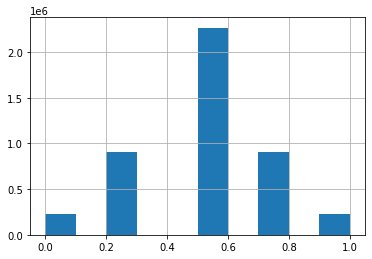

In [ ]:
targets.target_20d.hist()

In [ ]:
targets.target_20d.value_counts()

0.50    2265869
0.25     901781
0.75     901592
1.00     225619
0.00     225495
Name: target_20d, dtype: int64

In [ ]:
ML_data = pd.merge(full_df.reset_index(), targets,
         on=["date", "bloomberg_ticker"]).set_index("date")

ML_data.dropna(inplace=True)
ML_data = ML_data[ML_data.index.weekday==4] # friday
ML_data = ML_data[ML_data.index.value_counts() > 50]

gc.collect()

150

In [ ]:
print(f'Number of eras in data: {len(ML_data.index.unique())}') # around 20 years of data

In [59]:
ML_data[list(sma_features + ema_features+ mfi_features + rsi_features) + ["bloomberg_ticker", "data_type", "target_20d"]]

,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50,mfi_14,mfi_21,rsi_14,rsi_21,bloomberg_ticker,data_type,target_20d
date,,,,,,,,,,,,,
2003-03-07,4.0,4.0,4.0,4.0,4.0,4.0,0.0,2.0,0.0,1.0,000270 KS,train,0.50
2003-03-07,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,0.0,1.0,000810 KS,train,0.50
2003-03-07,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,002790 KS,train,1.00
2003-03-07,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,2.0,003490 KS,train,0.50
2003-03-07,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,004170 KS,train,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,ZUO US,validation,0.75
2022-01-07,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,ZURN SW,validation,0.50
2022-01-07,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,ZWS US,validation,0.50


## Modelling

In [61]:
train_data = ML_data[ML_data['data_type'] == 'train']
test_data = ML_data[ML_data['data_type'] == 'validation']
gc.collect()

14298

In [62]:
feature_names = [
                 f for f in train_data.columns for y in ['lag', 'abs_diff'] if y in f
                 ] + list(new_indicators)
len(feature_names)

80

In [63]:
corrs = train_data.groupby(train_data.index).apply(
    lambda x: x[feature_names+[TARGET_NAME]].corr()[TARGET_NAME]
    )
mean_corr = corrs[feature_names].mean(0)
mean_corr.abs().sort_values()

target_20d
mfi_14_abs_diff_10    0.000024
sma_50_abs_diff_5     0.000040
ema_7_abs_diff_5      0.000056
ema_50_abs_diff_10    0.000104
ema_50_abs_diff_15    0.000243
                        ...   
sma_21_lag_10         0.017026
ema_7_lag_10          0.017035
ema_21                0.017124
sma_7                 0.017390
ema_7                 0.017400
Length: 80, dtype: float64

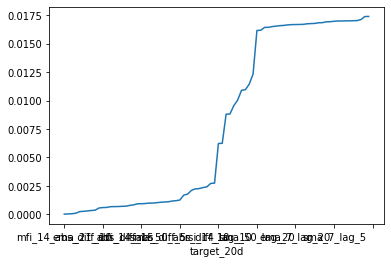

In [64]:
mean_corr.abs().sort_values().plot()

In [65]:
ML_data

,mfi_14,mfi_21,rsi_14,rsi_21,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50,adj_close,sma_7 minus sma_21,sma_7 minus sma_50,sma_21 minus sma_50,ema_7 minus ema_21,ema_7 minus ema_50,ema_21 minus ema_50,rsi_14 minus rsi_21,mfi_14 minus mfi_21,bloomberg_ticker,mfi_14_lag_5,mfi_14_lag_10,mfi_14_lag_15,mfi_14_lag_20,mfi_21_lag_5,mfi_21_lag_10,mfi_21_lag_15,mfi_21_lag_20,rsi_14_lag_5,rsi_14_lag_10,rsi_14_lag_15,rsi_14_lag_20,rsi_21_lag_5,rsi_21_lag_10,rsi_21_lag_15,rsi_21_lag_20,sma_7_lag_5,sma_7_lag_10,sma_7_lag_15,sma_7_lag_20,sma_21_lag_5,sma_21_lag_10,sma_21_lag_15,sma_21_lag_20,sma_50_lag_5,sma_50_lag_10,sma_50_lag_15,sma_50_lag_20,ema_7_lag_5,ema_7_lag_10,ema_7_lag_15,ema_7_lag_20,ema_21_lag_5,ema_21_lag_10,ema_21_lag_15,ema_21_lag_20,ema_50_lag_5,ema_50_lag_10,ema_50_lag_15,ema_50_lag_20,mfi_14_abs_diff_5,mfi_14_abs_diff_10,mfi_14_abs_diff_15,mfi_21_abs_diff_5,mfi_21_abs_diff_10,mfi_21_abs_diff_15,rsi_14_abs_diff_5,rsi_14_abs_diff_10,rsi_14_abs_diff_15,rsi_21_abs_diff_5,rsi_21_abs_diff_10,rsi_21_abs_diff_15,sma_7_abs_diff_5,sma_7_abs_diff_10,sma_7_abs_diff_15,sma_21_abs_diff_5,sma_21_abs_diff_10,sma_21_abs_diff_15,sma_50_abs_diff_5,sma_50_abs_diff_10,sma_50_abs_diff_15,ema_7_abs_diff_5,ema_7_abs_diff_10,ema_7_abs_diff_15,ema_21_abs_diff_5,ema_21_abs_diff_10,ema_21_abs_diff_15,ema_50_abs_diff_5,ema_50_abs_diff_10,ema_50_abs_diff_15,friday_date,data_type,target_4d,target_20d
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-03-07,0.0,2.0,0.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,000270 KS,1.0,3.0,3.0,2.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0,3.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,0.0,1.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20030307,train,0.25,0.50
2003-03-07,2.0,2.0,0.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,000810 KS,1.0,1.0,0.0,4.0,2.0,1.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,1.0,4.0,1.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20030307,train,0.25,0.50
2003-03-07,2.0,4.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,002790 KS,3.0,4.0,2.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,2.0,2.0,0.0,3.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20030307,train,0.75,1.00
2003-03-07,0.0,0.0,0.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,3.0,4.0,1.0,2.0,3.0,0.0,0.0,003490 KS,0.0,0.0,2.0,3.0,2.0,3.0,1.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20030307,train,0.25,0.50
2003-03-07,4.0,4.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,2.0,3.0,0.0,1.0,2.0,1.0,2.0,004170 KS,4.0,3.0,2.0,2.0,4.0,0.0,1.0,1.0,2.0,2.0,3.0,0.0,1.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20030307,train,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,4.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,ZUO US,2.0,0.0,4.0,4.0,0.0,1.0,2.

In [66]:
# choose data as of most recent friday
last_friday = datetime.now() + relativedelta(weekday=FR(-1))
date_string = last_friday.strftime('%Y-%m-%d')
live_data = full_df[full_df.index == date_string].copy()

# get data from the day before, for markets that were closed
last_thursday = last_friday - relativedelta(days=1)
thursday_date_string = last_thursday.strftime('%Y-%m-%d')
thursday_data = full_df[full_df.index == thursday_date_string]

# Only select tickers than aren't already present in live_data
thursday_data = thursday_data[
    ~thursday_data.bloomberg_ticker.isin(live_data.bloomberg_ticker.values)
].copy()

live_data = pd.concat([live_data, thursday_data])

In [67]:
live_data

,mfi_14,mfi_21,rsi_14,rsi_21,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50,adj_close,sma_7 minus sma_21,sma_7 minus sma_50,sma_21 minus sma_50,ema_7 minus ema_21,ema_7 minus ema_50,ema_21 minus ema_50,rsi_14 minus rsi_21,mfi_14 minus mfi_21,bloomberg_ticker,mfi_14_lag_5,mfi_14_lag_10,mfi_14_lag_15,mfi_14_lag_20,mfi_21_lag_5,mfi_21_lag_10,mfi_21_lag_15,mfi_21_lag_20,rsi_14_lag_5,rsi_14_lag_10,rsi_14_lag_15,rsi_14_lag_20,rsi_21_lag_5,rsi_21_lag_10,rsi_21_lag_15,rsi_21_lag_20,sma_7_lag_5,sma_7_lag_10,sma_7_lag_15,sma_7_lag_20,sma_21_lag_5,sma_21_lag_10,sma_21_lag_15,sma_21_lag_20,sma_50_lag_5,sma_50_lag_10,sma_50_lag_15,sma_50_lag_20,ema_7_lag_5,ema_7_lag_10,ema_7_lag_15,ema_7_lag_20,ema_21_lag_5,ema_21_lag_10,ema_21_lag_15,ema_21_lag_20,ema_50_lag_5,ema_50_lag_10,ema_50_lag_15,ema_50_lag_20,mfi_14_abs_diff_5,mfi_14_abs_diff_10,mfi_14_abs_diff_15,mfi_21_abs_diff_5,mfi_21_abs_diff_10,mfi_21_abs_diff_15,rsi_14_abs_diff_5,rsi_14_abs_diff_10,rsi_14_abs_diff_15,rsi_21_abs_diff_5,rsi_21_abs_diff_10,rsi_21_abs_diff_15,sma_7_abs_diff_5,sma_7_abs_diff_10,sma_7_abs_diff_15,sma_21_abs_diff_5,sma_21_abs_diff_10,sma_21_abs_diff_15,sma_50_abs_diff_5,sma_50_abs_diff_10,sma_50_abs_diff_15,ema_7_abs_diff_5,ema_7_abs_diff_10,ema_7_abs_diff_15,ema_21_abs_diff_5,ema_21_abs_diff_10,ema_21_abs_diff_15,ema_50_abs_diff_5,ema_50_abs_diff_10,ema_50_abs_diff_15
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-25,1.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,3.0,4.0,0.0,3.0,4.0,0.0,3.0,000060 KS,4.0,1.0,1.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0,1.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-25,0.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,0.0,000080 KS,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-25,1.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,000100 KS,4.0,3.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-25,2.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,000120 KS,4.0,3.0,2.0,0.0,1.0,3.0,0.0,2.0,3.0,3.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,2.0,2.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-25,1.0,0.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,1.0,3.0,2.0,2.0,3.0,3.0,000210 KS,4.0,4.0,0.0,0.0,4.0,4.0,1.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0,0.0,3.0,2.0,3.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,3.0,4.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,4.0,2.0,3.0,4.0,1.0,2.0,ZURN SW,3.0,4.0,2.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0

In [68]:
from xgboost import XGBRegressor
model = XGBRegressor(
    subsample=0.5,
    n_estimators=200,
    tree_method="gpu_hist")

gc.collect()
model.fit(train_data[feature_names].values, 
          train_data[TARGET_NAME].values,
          eval_set=[(test_data[feature_names].values, 
          test_data[TARGET_NAME].values)], 
          verbose = 100)

[05:59:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.214823
[100]	validation_0-rmse:0.214817
[199]	validation_0-rmse:0.214834


XGBRegressor(n_estimators=200, subsample=0.5, tree_method='gpu_hist')

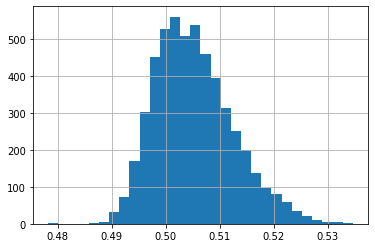

In [69]:
train_data[PREDICTION_NAME] = model.predict(train_data[feature_names].values)
test_data[PREDICTION_NAME] = model.predict(test_data[feature_names].values)
live_data[PREDICTION_NAME] = model.predict(live_data[feature_names].values)

#show prediction distribution, most should around the center
live_data[PREDICTION_NAME].hist(bins=30)

In [70]:
# From Jason Rosenfeld's notebook
# https://twitter.com/jrosenfeld13/status/1315749231387443202?s=20

def score(df):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

In [71]:
# spearman scores by era
train_era_scores = train_data.groupby(train_data.index).apply(score)
test_era_scores = test_data.groupby(test_data.index).apply(score)

Mean Correlation: 0.0421
Median Correlation: 0.0407
Standard Deviation: 0.0280


Mean Pseudo-Sharpe: 1.5059
Median Pseudo-Sharpe: 1.4575


Hit Rate (% positive eras): 96.49%


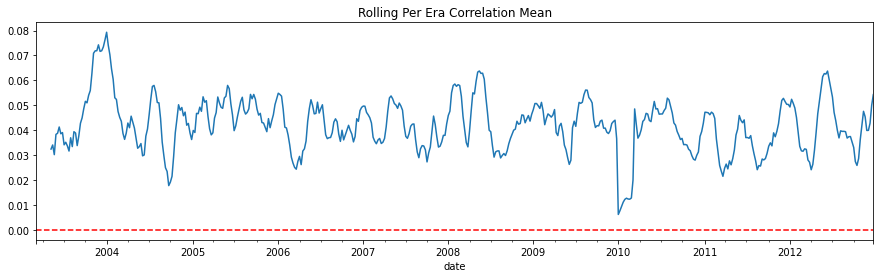

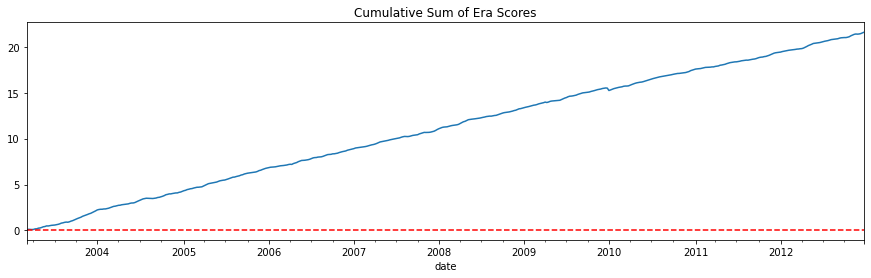

In [72]:
#train scores, in-sample and will be significantly overfit
run_analytics(train_era_scores)

Mean Correlation: 0.0146
Median Correlation: 0.0150
Standard Deviation: 0.0193


Mean Pseudo-Sharpe: 0.7550
Median Pseudo-Sharpe: 0.7774


Hit Rate (% positive eras): 78.89%


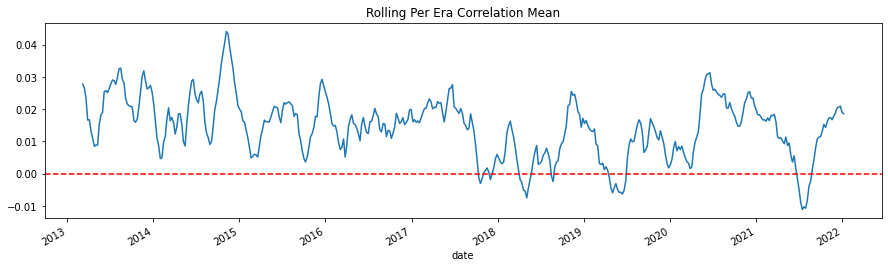

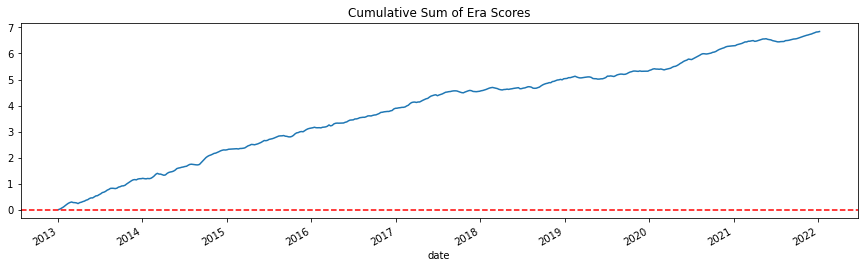

In [77]:
#test scores, out of sample
# These are not exact scores you'll get on 
# diagnostics due to feature neutralization

run_analytics(test_era_scores)

In [78]:
live_data

,mfi_14,mfi_21,rsi_14,rsi_21,sma_7,sma_21,sma_50,ema_7,ema_21,ema_50,adj_close,sma_7 minus sma_21,sma_7 minus sma_50,sma_21 minus sma_50,ema_7 minus ema_21,ema_7 minus ema_50,ema_21 minus ema_50,rsi_14 minus rsi_21,mfi_14 minus mfi_21,bloomberg_ticker,mfi_14_lag_5,mfi_14_lag_10,mfi_14_lag_15,mfi_14_lag_20,mfi_21_lag_5,mfi_21_lag_10,mfi_21_lag_15,mfi_21_lag_20,rsi_14_lag_5,rsi_14_lag_10,rsi_14_lag_15,rsi_14_lag_20,rsi_21_lag_5,rsi_21_lag_10,rsi_21_lag_15,rsi_21_lag_20,sma_7_lag_5,sma_7_lag_10,sma_7_lag_15,sma_7_lag_20,sma_21_lag_5,sma_21_lag_10,sma_21_lag_15,sma_21_lag_20,sma_50_lag_5,sma_50_lag_10,sma_50_lag_15,sma_50_lag_20,ema_7_lag_5,ema_7_lag_10,ema_7_lag_15,ema_7_lag_20,ema_21_lag_5,ema_21_lag_10,ema_21_lag_15,ema_21_lag_20,ema_50_lag_5,ema_50_lag_10,ema_50_lag_15,ema_50_lag_20,mfi_14_abs_diff_5,mfi_14_abs_diff_10,mfi_14_abs_diff_15,mfi_21_abs_diff_5,mfi_21_abs_diff_10,mfi_21_abs_diff_15,rsi_14_abs_diff_5,rsi_14_abs_diff_10,rsi_14_abs_diff_15,rsi_21_abs_diff_5,rsi_21_abs_diff_10,rsi_21_abs_diff_15,sma_7_abs_diff_5,sma_7_abs_diff_10,sma_7_abs_diff_15,sma_21_abs_diff_5,sma_21_abs_diff_10,sma_21_abs_diff_15,sma_50_abs_diff_5,sma_50_abs_diff_10,sma_50_abs_diff_15,ema_7_abs_diff_5,ema_7_abs_diff_10,ema_7_abs_diff_15,ema_21_abs_diff_5,ema_21_abs_diff_10,ema_21_abs_diff_15,ema_50_abs_diff_5,ema_50_abs_diff_10,ema_50_abs_diff_15,signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-25,1.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,3.0,4.0,0.0,3.0,4.0,0.0,3.0,000060 KS,4.0,1.0,1.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0,1.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.501223
2022-02-25,0.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,0.0,000080 KS,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507137
2022-02-25,1.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,000100 KS,4.0,3.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503678
2022-02-25,2.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,000120 KS,4.0,3.0,2.0,0.0,1.0,3.0,0.0,2.0,3.0,3.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,2.0,2.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497873
2022-02-25,1.0,0.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,1.0,3.0,2.0,2.0,3.0,3.0,000210 KS,4.0,4.0,0.0,0.0,4.0,4.0,1.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0,0.0,3.0,2.0,3.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,3.0,4.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,4.0,2.0,3.0,4.0,1.0,2.0,ZURN SW,3.0,4.0,2.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,

You can simply run this without any modification

In [79]:
diagnostic_df = pd.concat([test_data, live_data])
diagnostic_df['friday_date'] = diagnostic_df.friday_date.fillna(
    last_friday.strftime('%Y%m%d')).astype(int)
diagnostic_df['data_type'] = diagnostic_df.data_type.fillna('live')

diagnostic_df[PREDICTION_NAME] = diagnostic_df.groupby('date')[PREDICTION_NAME].rank(pct=True, method="first")

diagnostic_df[["bloomberg_ticker", "friday_date", "data_type", "signal"]].reset_index(
    drop=True
).to_csv("signal_xgboost.csv", index=False)

In [80]:
diagnostic_df[["bloomberg_ticker", "friday_date", "data_type", "signal"]]

,bloomberg_ticker,friday_date,data_type,signal
date,,,,
2013-01-04,000060 KS,20130104,validation,0.824865
2013-01-04,000080 KS,20130104,validation,0.768668
2013-01-04,000100 KS,20130104,validation,0.841801
2013-01-04,000120 KS,20130104,validation,0.648961
2013-01-04,000210 KS,20130104,validation,0.365281
...,...,...,...,...
2022-02-24,ZURN SW,20220225,live,0.195672
2022-02-24,ZWS US,20220225,live,0.619125
2022-02-24,ZY US,20220225,live,0.963704


## Uploading predictions using your API keys 🚀

Find your Numerapi public and private keys from https://numer.ai/account

To create a key for submission only, 

`Settings -> Create API key -> select "Upload Predictions" -> Save`


In [ ]:
# NameOfYourAI
# Add keys between the quotes
public_id = "YourKeys"
secret_key = "YourKeys"
model_id = "YourKeys"
napi = numerapi.SignalsAPI(public_id=public_id, secret_key=secret_key)

In [ ]:
submission_id = napi.upload_predictions(f"/content/example_signal_upload.csv", model_id=model_id)